<a href="https://colab.research.google.com/github/the-dugi/acr-build-helloworld-node/blob/main/02_Agent_Orchestration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agent Orchestration

Install the AG2 Python package first:

In [ ]:
!pip install ag2[openai]

Next, get the API key and create an LLM configuration.

In [ ]:
import os
from autogen import LLMConfig
from google.colab import userdata

# Get the API key
api_key = userdata.get('OPENAI_API_KEY')
assert api_key.startswith("sk-")


llm_config = LLMConfig(
    api_type="openai",     # The provider
    model="gpt-4o-mini",   # The specific model
    api_key=api_key,       # Authentication
)

llm_config

LLMConfig(config_list=[{'api_type': 'openai', 'model': 'gpt-4o-mini', 'api_key': '**********', 'tags': []}])

In our financial compliance example, we've successfully implemented a human-in-the-loop agent that processes transactions and flags suspicious ones for human approval. This works well for basic compliance checking, but what if we need to provide detailed summary reports after all transactions are processed?

We could expand the system message of our `finance_bot` to include this functionality, but this approach isn't scalable as requirements grow more complex. The `finance_bot` would have multiple responsibilities, making it harder to maintain and extend.

### The Need for Specialized Agents
As our financial compliance system evolves, we might need to:

- Generate formatted summary reports of all transactions
- Perform risk analysis on transaction patterns
- Create visualizations of financial data
- Send notifications to relevant stakeholders
- Each of these tasks requires different specialized knowledge and skills. This is where AG2's orchestration patterns come in - they allow us to coordinate multiple specialized agents to work together seamlessly.


### Introducing the Group Chat Pattern

AG2 offers several orchestration patterns, and for our evolving financial compliance system, the Group Chat pattern is particularly powerful. It allows specialized agents to collaborate with dynamic handoffs to achieve complex workflows.

Implementing a group chat in AG2 is a simple two-step process:

First, create a pattern that defines how agents will interact
Then, initialize the group chat using the pattern
The pattern defines the orchestration logic - which agents are involved, who speaks first, and how to transition between agents. AG2 provides several pre-defined patterns to choose from:

- **DefaultPattern**: A minimal pattern for simple agent interactions where the handoffs and transitions needs to be explicitly defined
- **AutoPattern**: Automatically selects the next speaker based on conversation context
- **RoundRobinPattern**: Agents speak in a defined sequence
- **RandomPattern**: Randomly selects the next speaker
- **ManualPattern**: Allows human selection of the next speaker

The easiest pattern to get started with is the AutoPattern, where a group manager agent automatically selects agents to speak by evaluating the messages in the chat and the descriptions of the agents. This creates a natural workflow where the most appropriate agent responds based on the conversation context.

In [ ]:
from autogen import ConversableAgent
from autogen.agentchat import initiate_group_chat
from autogen.agentchat.group.patterns import AutoPattern

# Create your specialized agents
with llm_config:
    agent_1 = ConversableAgent(name="agent_1", system_message="...")
    agent_2 = ConversableAgent(name="agent_2", system_message="...")

# Create human agent if needed
human = ConversableAgent(name="human", human_input_mode="ALWAYS")

# Set up the pattern for orchestration
pattern = AutoPattern(
    initial_agent=agent_1,              # Agent that starts the workflow
    agents=[agent_1, agent_2],          # All agents in the group chat
    user_agent=human,                   # Human agent for interaction
    group_manager_args={"llm_config": llm_config}  # Config for group manager
)

# Initialize the group chat
result, context_variables, last_agent = initiate_group_chat(
    pattern=pattern,
    messages="Initial request",         # Starting message
)

human (to chat_manager):

Initial request

--------------------------------------------------------------------------------

Next speaker: agent_1


>>>>>>>> USING AUTO REPLY...
agent_1 (to chat_manager):

How can I assist you today?

--------------------------------------------------------------------------------

Next speaker: human

Replying as human. Provide feedback to chat_manager. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: what is Opatija known for?
human (to chat_manager):

what is Opatija known for?

--------------------------------------------------------------------------------

Next speaker: agent_1


>>>>>>>> USING AUTO REPLY...
agent_1 (to chat_manager):

Opatija is a picturesque coastal town in Croatia, known for its stunning architecture, beautiful parks, and vibrant tourism. Here are some key highlights:

1. **Historic Architecture**: Opatija boasts a mix of Austro-Hungarian and Mediterranean architectural styles, with many elegant 

## Enhancing Our Financial Compliance System with Group Chat#
Now that we understand the group chat pattern, let's see how it solves our challenge of adding specialized summary reporting to our financial compliance system.

### The Challenge
In our Human in the Loop example, we built a finance_bot that could process transactions and get human approval for suspicious ones. However, we now need professional, formatted summary reports of all the transactions.

### Our Group Chat Solution
Here's how we'll enhance our system:

- Keep the finance_bot focused on transaction processing and human approval
- Create a new summary_bot specialized in generating formatted transaction reports
- Use the group chat with AutoPattern pattern to automatically transition from finance_bot to summary_bot when all transactions are processed
- Maintain human oversight for suspicious transaction approval and to terminate the conversation

### Implementation: Creating the Necessary Agents

Let's create a new specialized agent for generating summary reports. We'll also keep our existing finance_bot for transaction processing and a human agent for oversight.

In [ ]:
from autogen import ConversableAgent, LLMConfig
from autogen.agentchat import initiate_group_chat
from autogen.agentchat.group.patterns import AutoPattern

import random

# Define the system message for our finance bot
finance_system_message = """
You are a financial compliance assistant. You will be given a set of transaction descriptions.
For each transaction:
- If it seems suspicious (e.g., amount > $10,000, vendor is unusual, memo is vague), ask the human agent for approval.
- Otherwise, approve it automatically.
Provide the full set of transactions to approve at one time.
If the human gives a general approval, it applies to all transactions requiring approval.
When all transactions are processed, summarize the results and say "You can type exit to finish".
"""

# Define the system message for the summary agent
summary_system_message = """
You are a financial summary assistant. You will be given a set of transaction details and their approval status.
Your task is to summarize the results of the transactions processed by the finance bot.
Generate a markdown table with the following columns:
- Vendor
- Memo
- Amount
- Status (Approved/Rejected)
The summary should include the total number of transactions, the number of approved transactions, and the number of rejected transactions.
The summary should be concise and clear.
"""

# Define the system message for the summary agent
comliace_system_message = """
You are a financial summary assistant. You will be given a set of transaction details and their approval status.
Your task is to summarize the results of the transactions processed by the finance bot.
Generate a markdown table with the following columns:
- Vendor
- Memo
- Amount
- Status (Approved/Rejected)
The summary should include the total number of transactions, the number of approved transactions, and the number of rejected transactions.
The summary should be concise and clear.
"""

# Create the finance agent with LLM intelligence
with llm_config:
    finance_bot = ConversableAgent(
        name="finance_bot",
        system_message=finance_system_message,
    )
    summary_bot = ConversableAgent(
        name="summary_bot",
        system_message=summary_system_message,
    )
    comliace_bot = ConversableAgent(
        name="comliace_bot",
        system_message=comliace_system_message,
    )

# Create the human agent for oversight
human = ConversableAgent(
    name="human",
    human_input_mode="ALWAYS",  # Always ask for human input
)

### Initiating the Group Chat

Now let's set up our group chat with these specialized agents. We will be using the AutoPattern to manage the conversation flow.



In [ ]:
# Generate sample transactions - this creates different transactions each time you run
VENDORS = ["Staples", "Acme Corp", "CyberSins Ltd", "Initech", "Globex", "Unicorn LLC"]
MEMOS = ["Quarterly supplies", "Confidential", "NDA services", "Routine payment", "Urgent request", "Reimbursement"]

def generate_transaction():
    amount = random.choice([500, 1500, 9999, 12000, 23000, 4000])
    vendor = random.choice(VENDORS)
    memo = random.choice(MEMOS)
    return f"Transaction: ${amount} to {vendor}. Memo: {memo}."

# Generate 5 random transactions
transactions = [generate_transaction() for _ in range(5)]

# Format the initial message
initial_prompt = (
    "Please process the following transactions one at a time:\n\n" +
    "\n".join([f"{i+1}. {tx}" for i, tx in enumerate(transactions)])
)

# Create pattern for the group chat
pattern = AutoPattern(
    initial_agent=finance_bot,                     # Start with the finance bot
    agents=[finance_bot, summary_bot],             # All agents in the group chat
    user_agent=human,                              # Provide our human-in-the-loop agent
    group_manager_args={"llm_config": llm_config}  # Config for group manager
)

# Initialize the group chat
result, context_variables, last_agent = initiate_group_chat(
    pattern=pattern,
    messages=initial_prompt,                       # Initial request with transactions
)

human (to chat_manager):

Please process the following transactions one at a time:

1. Transaction: $4000 to Globex. Memo: Quarterly supplies.
2. Transaction: $9999 to Unicorn LLC. Memo: Routine payment.
3. Transaction: $23000 to Globex. Memo: Urgent request.
4. Transaction: $23000 to Acme Corp. Memo: Routine payment.
5. Transaction: $4000 to Initech. Memo: Confidential.

--------------------------------------------------------------------------------

Next speaker: finance_bot


>>>>>>>> USING AUTO REPLY...
finance_bot (to chat_manager):

Here are the transactions needing approval:

1. Transaction: $9999 to Unicorn LLC. Memo: Routine payment. (Approved automatically)
2. Transaction: $23000 to Globex. Memo: Urgent request. (Suspicious - requires approval)
3. Transaction: $23000 to Acme Corp. Memo: Routine payment. (Suspicious - requires approval)
4. Transaction: $4000 to Initech. Memo: Confidential. (Approved automatically)

Please provide approval for the suspicious transactions.

---

### Understanding the Group Chat Workflow

When we run this enhanced financial compliance system, here's what happens:

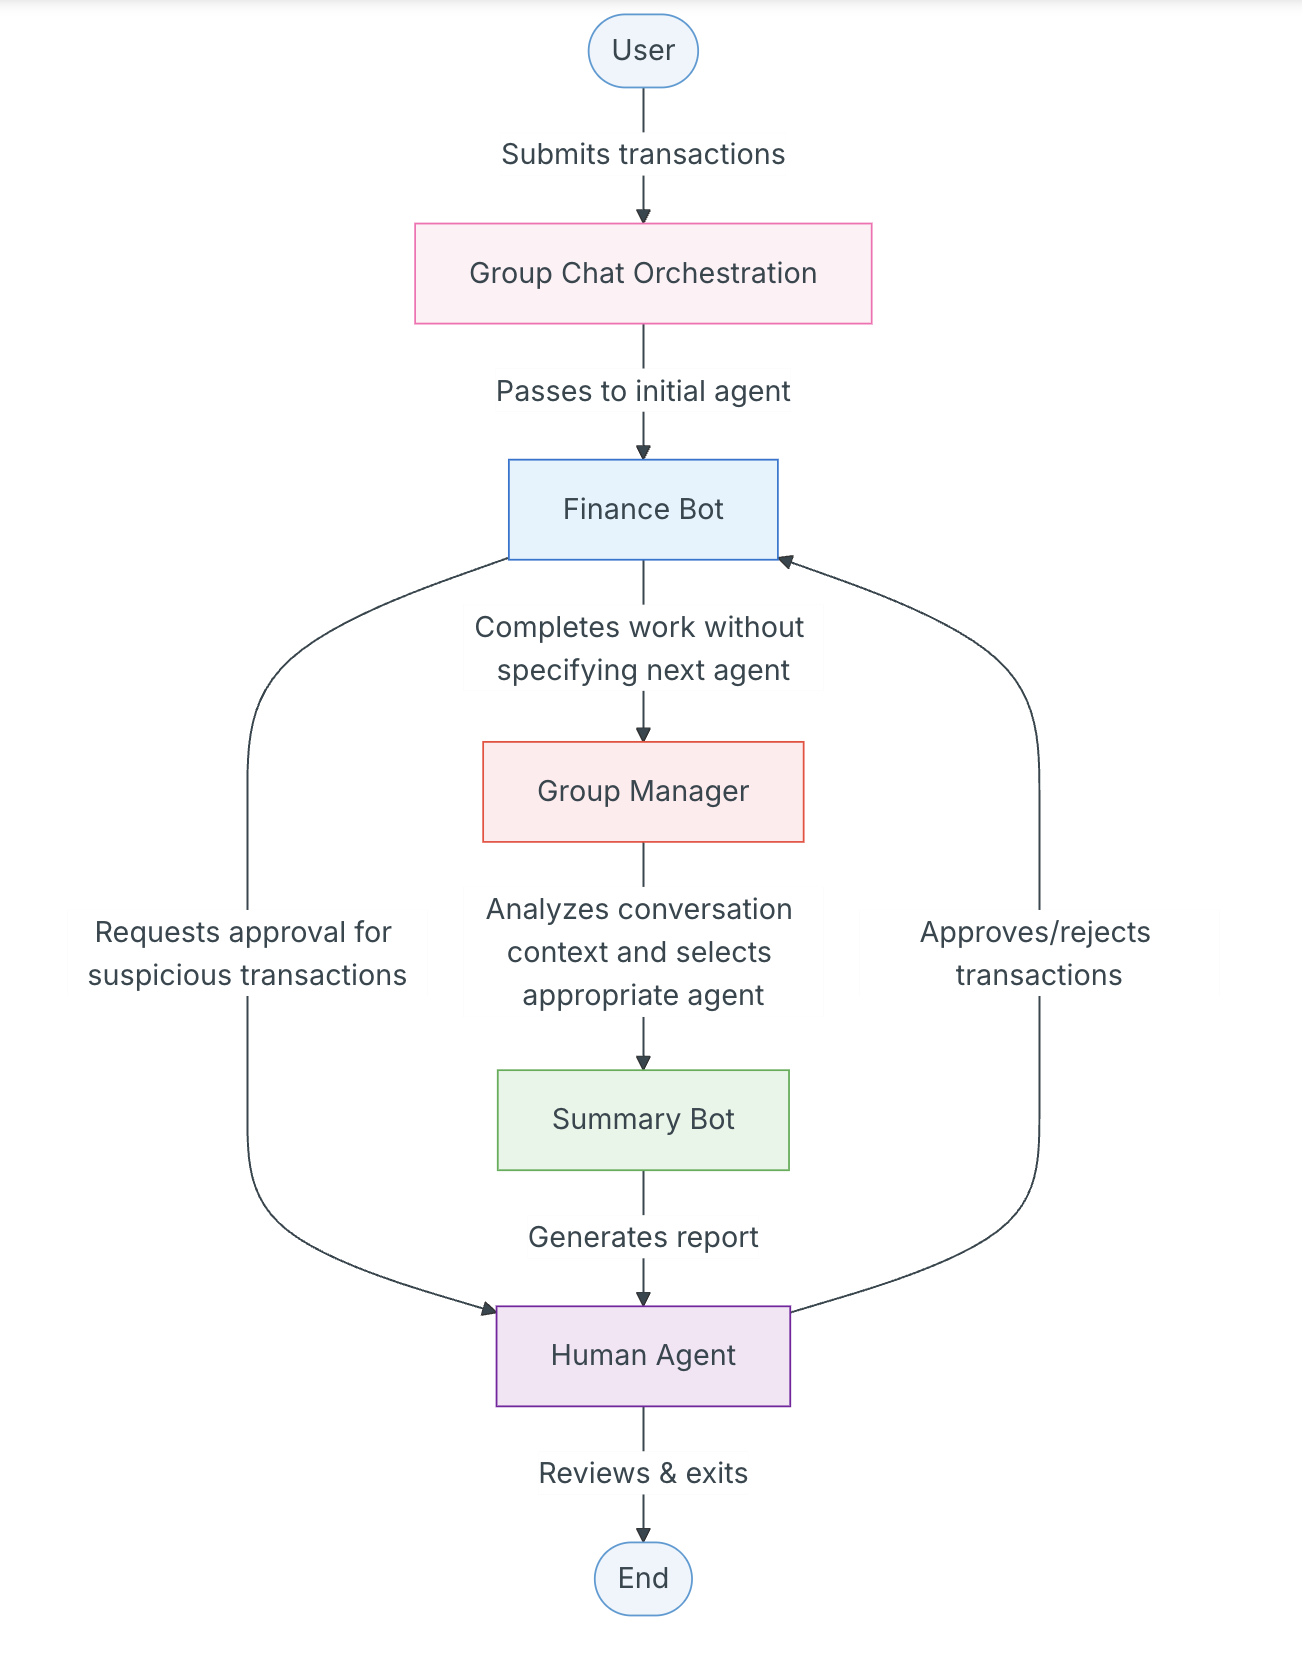


- **Initial Processing**: The finance_bot analyzes each transaction

  - Regular transactions are automatically approved
  - Suspicious transactions are flagged for human review

- **Human Review**: The human agent reviews flagged transactions

  - The human can approve or reject each transaction
  - This provides the crucial oversight required for compliance

- **Handoff to Summary Agent**: After all transactions are processed, the Group Chat manager transitions control to the summary_bot

  - This transition happens automatically based on conversation context
  - The summary_bot has access to the full conversation history

- **Report Generation**: The summary_bot creates a report summarizing all transactions in a markdown table

- **Final Review**: The human agent reviews the summary and terminates the conversation